In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time

## **Class implementation**

In [87]:
def fitness_magic_square_bis(individual: np.ndarray, magic_number: int):
    """Calculates the number of rows/columns/diagonals that don't sum the magic number. The least, the better"""

    L = len(individual)
    bad_sums = 0

    for i in range(L):
        if np.sum(individual[i]) != magic_number: # check row sum
            bad_sums += 1
        if np.sum([row[i] for row in individual]) != magic_number: # check column sum
            bad_sums += 1

    if np.sum([individual[i][i] for i in range(L)]) != magic_number: # check primary diagonal
        bad_sums += 1

    if np.sum([individual[i][L-i-1] for i in range(L)]) != magic_number: # check secondary diagonal
        bad_sums += 1

    return bad_sums

def fitness_magic_square(individual: np.ndarray, magic_number: int):
    """Calculates the sums of rows/columns/diagonals and absolute value with magic number. The lower the abs, the better"""

    row_sums  = np.sum(individual, axis=1)
    col_sums  = np.sum(individual, axis=0)
    diag_sum1 = np.sum(np.diag(individual))
    diag_sum2 = np.sum(np.diag(np.fliplr(individual)))

    fitness = (
        np.sum(abs(row_sums - magic_number)) +
        np.sum(abs(col_sums - magic_number)) +
        abs(diag_sum1 - magic_number) +
        abs(diag_sum2 - magic_number)
    )

    return int(fitness)

In [137]:
class AG_Magic_Square():
    def __init__(self, population_size: int, N: int):
        """Create the population"""

        self.magic_number = int(N*(N**2 + 1) / 2)
        self.population = []
        self.fitnesses  = []
        self.all_nums = N**2

        for _ in range(population_size):
            valores = np.random.permutation(self.all_nums) + 1  # valores entre 1 y N^2
            individuo = valores.reshape(N, N)
            self.population.append(individuo)
        
        self.population = np.array(self.population)

    def sort_pop(self, fitness_function, reverse_sort: bool) -> None:
        """Sort population by fitness function. Return tuple with population list and fitness list"""

        fitness_list = np.array([fitness_function(ind, self.magic_number) for ind in self.population])
        sorted_indices = np.argsort(fitness_list)[::-1] if reverse_sort else np.argsort(fitness_list)
        self.population = self.population[sorted_indices]
        self.fitnesses = fitness_list[sorted_indices]
    
    def select(self, T: int) -> np.ndarray[np.ndarray]:
        """Return a copy of an indivudual by tournament selection. Population already ordered by fitness"""

        choices=np.random.choice(len(self.population), size=T, replace=False)
        return self.population[np.min(choices)]
    
    def crossover(self, parent1: np.ndarray[np.ndarray], parent2: np.ndarray[np.ndarray], pcross: float) -> tuple[np.ndarray[np.ndarray], np.ndarray[np.ndarray]]:
        """Performs crossover, ensuring no duplicates and all numbers present."""
        
        if random.random() < pcross:
            child1 = np.zeros_like(parent1)
            child2 = np.zeros_like(parent2)
            
            suma_filas1 = parent1.sum(axis=1)
            suma_columnas1 = parent1.sum(axis=0)
            suma_filas2 = parent2.sum(axis=1)
            suma_columnas2 = parent2.sum(axis=0)

            filas_validas1 = np.where(suma_filas1 == self.magic_number)[0]
            columnas_validas1 = np.where(suma_columnas1 == self.magic_number)[0]
            filas_validas2 = np.where(suma_filas2 == self.magic_number)[0]
            columnas_validas2 = np.where(suma_columnas2 == self.magic_number)[0]
            # copiar a cada hijo la mayor cantidad de estructuras con suma válida
            if len(filas_validas1) >= len(columnas_validas1):
            # if random.random() < 0.5:
                child2[filas_validas1] = parent1[filas_validas1]
            else:
                child2[:, columnas_validas1] = parent1[:, columnas_validas1]
            if len(filas_validas2) >= len(columnas_validas2):
            # if random.random() < 0.5:
                child1[filas_validas2] = parent2[filas_validas2]
            else:
                child1[:, columnas_validas2] = parent2[:, columnas_validas2]
                
            rest_values1 = np.setdiff1d(np.arange(1, self.all_nums+1), np.unique(child1))
            random.shuffle(rest_values1)
            rest_values2 = np.setdiff1d(np.arange(1, self.all_nums+1), np.unique(child2))
            random.shuffle(rest_values2)
            
            vacias1 = child1 == 0
            child1[vacias1] = rest_values1
            vacias2 = child2 == 0
            child2[vacias2] = rest_values2
        else:
            child1 = np.copy(parent1)
            child2 = np.copy(parent2)
            
        return child1, child2

    def mutate(self, individual: np.ndarray[np.ndarray], pmut: float) -> np.ndarray[np.ndarray]:
        """Mutate an individual. Return mutated individual"""
    
        def mutate_swap(individual: np.ndarray[np.ndarray]) -> np.ndarray[np.ndarray]:
            """Swap random cells"""
            row1, col1, row2, col2 = random.choices(range(len(individual)), k=4)
            temp1, temp2 = individual[row1][col1], individual[row2][col2]
            individual[row1][col1], individual[row2][col2] = individual[row2][col2], individual[row1][col1]
            individual[row2][col2], individual[row1][col1] = temp1, temp2
            return individual            
        
        def mutate_shuffle_row(individual: np.ndarray[np.ndarray]) -> np.ndarray[np.ndarray]:
            """Shuffle a random row"""
            row_index = random.choice(range(len(individual)))
            random.shuffle(individual[row_index])
            return individual

        def mutate_shuffle_column(individual: np.ndarray[np.ndarray]) -> np.ndarray[np.ndarray]:
            """Shuffle a random column"""
            column_index = random.choice(range(len(individual)))
            random.shuffle(individual[:,column_index])
            return individual
        
        def swap_subblocks(individual: np.ndarray[np.ndarray]):
            N = individual.shape[0]  # Suponemos un cuadrado NxN
            block_size = 2
            
            # Asegurarnos de que el tamaño del bloque sea válido
            if block_size > N or N % block_size != 0:
                raise ValueError("El tamaño del bloque debe ser divisor del tamaño del array.")
            
            # Calcular posibles posiciones de los bloques
            positions = list(range(0, N, block_size))
            
            # Elegir dos posiciones aleatorias (coordenadas de la esquina superior izquierda de los bloques)
            (x1, y1), (x2, y2) = np.random.choice(positions, 2, replace=False), np.random.choice(positions, 2, replace=False)
            
            # Seleccionar los subbloques
            block1 = individual[x1:x1 + block_size, y1:y1 + block_size]
            block2 = individual[x2:x2 + block_size, y2:y2 + block_size]
            
            # Intercambiar los bloques
            individual[x1:x1 + block_size, y1:y1 + block_size] = block2
            individual[x2:x2 + block_size, y2:y2 + block_size] = block1
            
            return individual

        if random.random() < pmut:
            # mutations = [mutate_swap, mutate_shuffle_row, mutate_shuffle_column, swap_subblocks]
            mutations = [mutate_swap, mutate_shuffle_row, mutate_shuffle_column]
            operator = random.choice(mutations)
            return operator(individual)
        else: 
            return individual

    def evolve(self, fitness_function, pmut=0.1, pcross=0.7, ngen=100, T=3, trace=50, reverse_sort=False, elitism=False) -> None:
        """Evolution procedure. Initial population already created"""

        for i in range(ngen):
            new_pop = np.empty((0, self.population[0].shape[0], self.population[0].shape[0]), dtype=int)
            self.sort_pop(fitness_function, reverse_sort)
            if elitism:
                new_pop = np.vstack([new_pop, [self.population[0]], [self.population[1]]])
            while new_pop.shape[0] != self.population.shape[0]:   
                individual1 = self.select(T)
                individual2 = self.select(T)
                child1, child2 = self.crossover(individual1, individual2, pcross)
                mutated1 = self.mutate(child1, pmut)
                mutated2 = self.mutate(child2, pmut)
                new_pop = np.vstack([new_pop, [mutated1], [mutated2]]) # wrapped in lists because of dimension difference
                
            self.population = np.array([*new_pop])

            if i % trace == 0 or i == ngen-1: # en la última gen se ordena
                self.sort_pop(fitness_function, reverse_sort)
                print(f"Nº gen: {i}, Best fitness: {self.fitnesses[0]}")

## **Visual test**

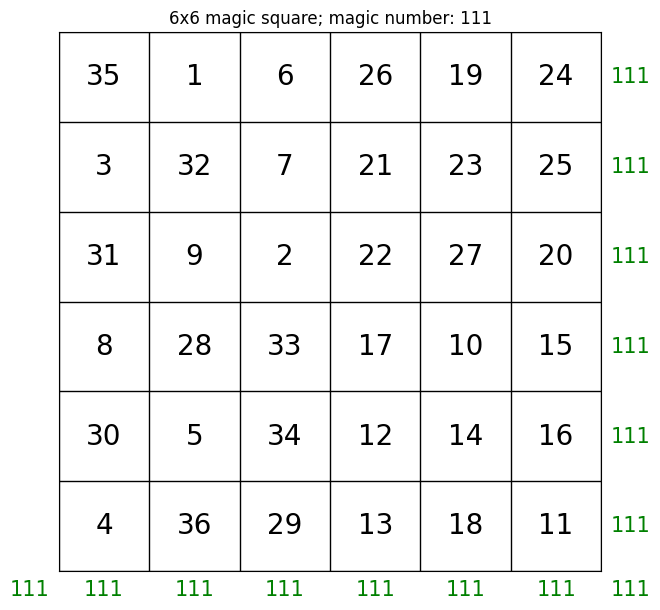

In [76]:
def plot_magic_square(square: np.ndarray):
    N = square.shape[0]
    magic_sum = int(N*(N**2+1) / 2)
    
    row_sums = square.sum(axis=1)
    col_sums = square.sum(axis=0)
    diag_sum1 = np.sum(np.diag(square))
    diag_sum2 = np.sum(np.diag(np.fliplr(square)))

    fig, ax = plt.subplots(figsize=(7, 7))
    
    # Remove extra space and ticks
    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(-0.5, N - 0.5)
    ax.invert_yaxis()  # Fix the upside-down issue
    ax.set_xticks([])
    ax.set_yticks([])
    
    # grid lines
    for i in range(N + 1):
        ax.plot([-0.5, N - 0.5], [i - 0.5, i - 0.5], color="black", linewidth=1)
        ax.plot([i - 0.5, i - 0.5], [-0.5, N - 0.5], color="black", linewidth=1)
    
    # numbers inside the grid
    for i in range(N):
        for j in range(N):
            ax.text(j, i, str(square[i, j]), va='center', ha='center', color='black', fontsize=20)
    
    # row sums to the right
    for i in range(N):
        row_color = 'green' if row_sums[i] == magic_sum else 'red'
        ax.text(N - 0.4, i, str(row_sums[i]), va='center', ha='left', color=row_color, fontsize=15)

    # column sums below
    for j in range(N):
        col_color = 'green' if col_sums[j] == magic_sum else 'red'
        ax.text(j, N - 0.4, str(col_sums[j]), va='top', ha='center', color=col_color, fontsize=15)
    
    # diagonal sums at the bottom corners
    diag_color1 = 'green' if diag_sum1 == magic_sum else 'red'
    diag_color2 = 'green' if diag_sum2 == magic_sum else 'red'
    ax.text(N - 0.4, N - 0.4, str(diag_sum1), va='top', ha='left', color=diag_color1, fontsize=15)
    ax.text(-0.6, N - 0.4, str(diag_sum2), va='top', ha='right', color=diag_color2, fontsize=15)
    
    plt.title(f"{N}x{N} magic square; magic number: {magic_sum}")
    plt.show()
# ----------------------------------------------
magic_square = [
    [35, 1, 6, 26, 19, 24],
    [3, 32, 7, 21, 23, 25],
    [31, 9, 2, 22, 27, 20],
    [8, 28, 33, 17, 10, 15],
    [30, 5, 34, 12, 14, 16],
    [4, 36, 29, 13, 18, 11]
]
magic_square = np.asarray(magic_square)
plot_magic_square(magic_square)

## **---------------------------Tests---------------------------**

Nº gen: 0, Best fitness: 125
Nº gen: 500, Best fitness: 24
Nº gen: 1000, Best fitness: 18
Nº gen: 1500, Best fitness: 15
Nº gen: 2000, Best fitness: 11
Nº gen: 2500, Best fitness: 10
Nº gen: 3000, Best fitness: 2
Nº gen: 3500, Best fitness: 2
Nº gen: 4000, Best fitness: 2
Nº gen: 4500, Best fitness: 2
Nº gen: 4999, Best fitness: 2
*******Tiempo evolución: 0 minutos y 29.09 segundos*******


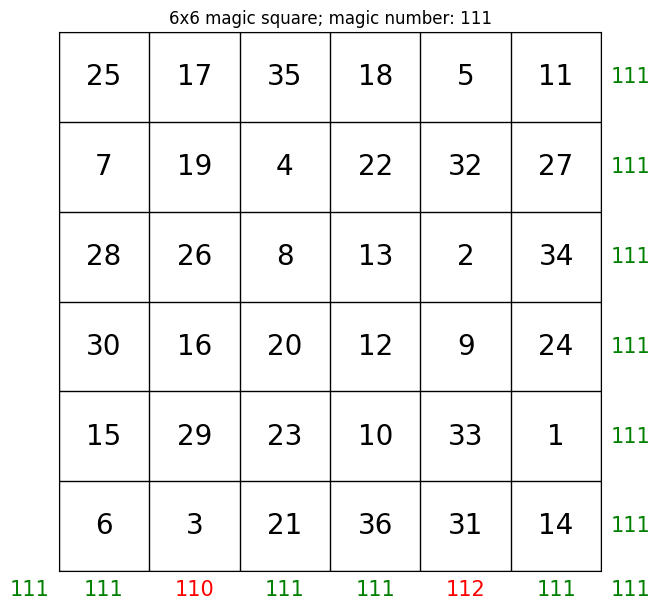

In [ ]:
N = 6 # tablero NxN
genetic_algorithm = AG_Magic_Square(100, N)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_magic_square, pmut=0.1, ngen=10000, T=6, trace=500)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

plot_magic_square(genetic_algorithm.population[0])

Nº gen: 0, Best fitness: 157
Nº gen: 500, Best fitness: 15
Nº gen: 1000, Best fitness: 10
Nº gen: 1500, Best fitness: 10
Nº gen: 2000, Best fitness: 10
Nº gen: 2500, Best fitness: 10
Nº gen: 3000, Best fitness: 10
Nº gen: 3500, Best fitness: 10
Nº gen: 4000, Best fitness: 10
Nº gen: 4500, Best fitness: 10
Nº gen: 5000, Best fitness: 10
Nº gen: 5500, Best fitness: 10
Nº gen: 6000, Best fitness: 10
Nº gen: 6500, Best fitness: 10
Nº gen: 7000, Best fitness: 10
Nº gen: 7500, Best fitness: 10
Nº gen: 8000, Best fitness: 10
Nº gen: 8500, Best fitness: 10
Nº gen: 9000, Best fitness: 10
Nº gen: 9500, Best fitness: 10
Nº gen: 9999, Best fitness: 10
*******Tiempo evolución: 1 minutos y 0.36 segundos*******


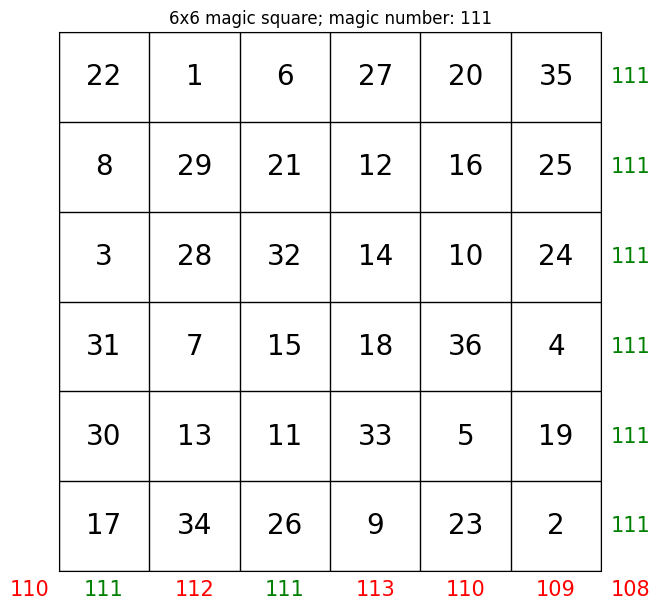

In [83]:
N = 6 # tablero NxN
genetic_algorithm = AG_Magic_Square(population_size=100, N=N)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_magic_square, pmut=0.1, ngen=10000, T=6, trace=500, reverse_sort=False)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

plot_magic_square(genetic_algorithm.population[0])

Nº gen: 0, Best fitness: 438
Nº gen: 500, Best fitness: 94
Nº gen: 1000, Best fitness: 75
Nº gen: 1500, Best fitness: 52
Nº gen: 2000, Best fitness: 30
Nº gen: 2500, Best fitness: 26
Nº gen: 3000, Best fitness: 25
Nº gen: 3500, Best fitness: 19
Nº gen: 4000, Best fitness: 15
Nº gen: 4500, Best fitness: 12
Nº gen: 5000, Best fitness: 9
Nº gen: 5500, Best fitness: 7
Nº gen: 6000, Best fitness: 7
Nº gen: 6500, Best fitness: 7
Nº gen: 7000, Best fitness: 7
Nº gen: 7500, Best fitness: 7
Nº gen: 8000, Best fitness: 7
Nº gen: 8500, Best fitness: 7
Nº gen: 9000, Best fitness: 7
Nº gen: 9500, Best fitness: 7
Nº gen: 9999, Best fitness: 7
*******Tiempo evolución: 1 minutos y 0.72 segundos*******
[[45 37 17 13 24  7 53 64]
 [20 63 23 32 35 28 18 41]
 [ 2 11 25 31 61 57 33 40]
 [43  8 56 51  6 38 22 36]
 [52 14 49 26 21 30 59  9]
 [27 62 29 54 58 10  1 19]
 [16  5 46 12 50 44 39 48]
 [55 60 15 42  4 47 34  3]]


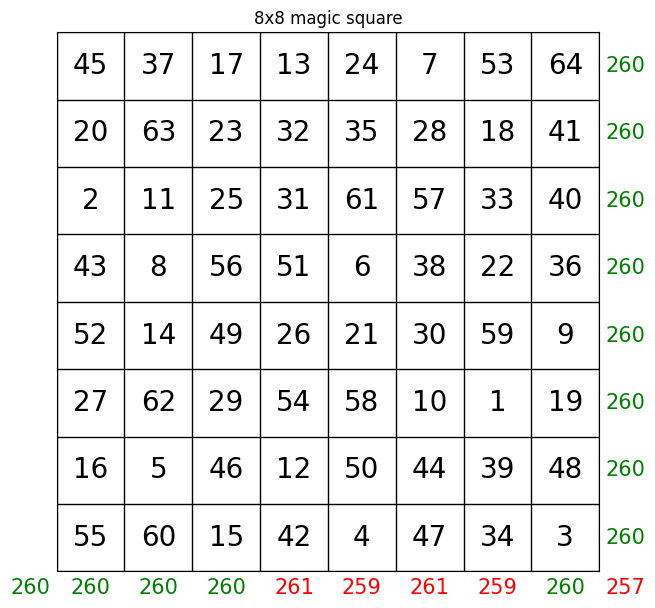

In [ ]:
N = 8 # tablero NxN
genetic_algorithm = AG_Magic_Square(population_size=100, N=N)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_magic_square, pmut=0.1, ngen=10000, T=6, trace=500, reverse_sort=False)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

plot_magic_square(genetic_algorithm.population[0])